## Imports

In [1]:
!echo $CUDA_VISIBLE_DEVICES

0,1


In [2]:
import torch
from torch import nn

In [3]:
%run -n ../train_report_generation.py

In [4]:
DEVICE = torch.device('cuda')
# DEVICE = torch.device('cpu')
DEVICE

device(type='cuda')

## Load stuff

### Load data

In [5]:
# %run ../datasets/iu_xray.py
%run ../datasets/__init__.py
%run ../training/report_generation/flat.py
%run ../training/report_generation/hierarchical.py

In [6]:
# hierarchical = is_decoder_hierarchical(decoder_name)
hierarchical = True
if hierarchical:
    create_dataloader = create_hierarchical_dataloader
else:
    create_dataloader = create_flat_dataloader

In [ ]:
BS = 150

dataset_kwargs = {
    'dataset_name': 'iu-x-ray',
    'max_samples': None,
    'batch_size': BS,
    'frontal_only': True,
    'image_size': (256, 256),
    'sort_samples': False,
    'masks': True,
    # 'num_workers': 0,
}

train_dataloader = prepare_data_report_generation(create_dataloader, dataset_type='train',
                                                  **dataset_kwargs)
VOCAB = train_dataloader.dataset.get_vocab()
val_dataloader = prepare_data_report_generation(create_dataloader, dataset_type='val',
                                                vocab=VOCAB,
                                                **dataset_kwargs)
len(train_dataloader.dataset)

Loading iu-x-ray/train dataset...
Loading iu-x-ray/val dataset...


In [ ]:
VOCAB_SIZE = len(VOCAB)
VOCAB_SIZE

#### Debug hierarchical dataloader

In [9]:
#
### %%debug

for batch in train_dataloader:
    break

In [10]:
batch.masks.min(), batch.masks.max()

(tensor(0), tensor(1))

In [11]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [12]:
%run ../utils/nlp.py

In [13]:
report_reader = ReportReader(train_dataloader.dataset.get_vocab())

In [16]:
item_idx = 1
report = batch.reports[item_idx]
mask = batch.masks[item_idx]
report.size(), mask.size()

(torch.Size([9, 22]), torch.Size([9, 256, 256]))

0: the cardiomediastinal silhouette is within normal limits for size and contour . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
1: the lungs are normally inflated without evidence of focal airspace disease , pleural effusion , or pneumothorax . PAD PAD PAD PAD
2: stable calcified granuloma within the right upper lung . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
3: no acute bone abnormality . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
4: PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
5: PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
6: PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
7: PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
8: PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


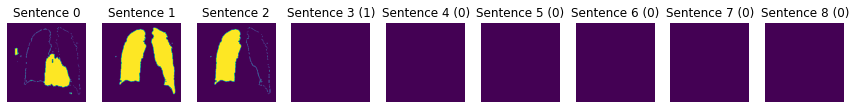

In [17]:
plt.figure(figsize=(15, 5))
n_sentences = mask.size(0)
n_cols = n_sentences

for i_sentence in range(n_sentences):
    submask = mask[i_sentence]
    
    title = f'Sentence {i_sentence}'
    
    min_value = submask.min().item()
    if min_value == submask.max().item():
        unique_value = min_value
        title += f' ({unique_value})'
    
    plt.subplot(1, n_cols, i_sentence + 1)
    plt.imshow(submask)
    plt.title(title)
    plt.axis('off')
    
    sentence = report_reader.idx_to_text(report[i_sentence])
    print(f'{i_sentence}: {sentence}')
    
plt.show()

### Create CNN2Seq model

In [11]:
%run ../models/classification/__init__.py
%run ../models/report_generation/cnn_to_seq.py
%run ../models/checkpoint/__init__.py

#### Load CNN

In [10]:
cnn_run_name = '0706_134245_covid-kaggle_tfs-small_lr1e-06'
debug_run = True

compiled_cnn = load_compiled_model_classification(cnn_run_name,
                                                  debug=debug_run,
                                                  device=DEVICE)
cnn = compiled_cnn.model

AssertionError: Run folder does not exist: /mnt/workspace/medical-ai/classification/models/debug/0706_134245_covid-kaggle_tfs-small_lr1e-06

#### ..or create CNN

In [12]:
cnn = create_cnn('mobilenet-v2', # resnet-50 # densenet-121
                 labels=[],
                 imagenet=True,
                 freeze=False,
                ).to(DEVICE)

#### Create Flat LSTM decoder

In [15]:
%run ../models/report_generation/decoder_lstm.py

In [16]:
decoder = LSTMDecoder(VOCAB_SIZE, 100, 100, cnn.features_size,
                      teacher_forcing=True).to(DEVICE)

#### ...or with attention

In [88]:
%run ./models/report_generation/decoder_lstm_att.py

In [89]:
decoder_att = LSTMAttDecoder(VOCAB_SIZE, 100, 100, cnn.features_size,
                             teacher_forcing=True).to(DEVICE)

#### ...or hierarchical decoder

In [13]:
%run ../models/report_generation/decoder_h_lstm_att_v2.py

In [14]:
decoder_h = HierarchicalLSTMAttDecoderV2(VOCAB_SIZE, 100, 100, cnn.features_size,
                                         teacher_forcing=True, attention=True).to(DEVICE)

#### Full model

In [15]:
model = CNN2Seq(cnn, decoder_h).to(DEVICE)

In [16]:
# model = nn.DataParallel(model)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

compiled_model = CompiledModel(model, optimizer, None, {})

### ...or Load CNN2Seq model

In [9]:
%run models/checkpoint/__init__.py

ERROR(12-22 15:41) File `'models/checkpoint/__init__.py'` not found.


In [10]:
# run_name = '0714_181427_lstm_lr0.0001_densenet-121'
# run_name = '0716_234501_h-lstm-att_lr0.0001_densenet-121'
# run_name = '0717_015057_h-lstm_lr0.0001_densenet-121'

# run_name = '0717_041434_lstm_lr0.0001_densenet-121'
# run_name = '0716_211601_lstm-att_lr0.0001_densenet-121'
# debug = False

# run_name = '0717_183321_lstm_lr0.0001_densenet-121_size256'
# run_name = '0717_184851_lstm_lr0.0001_densenet-121_size256'
debug = False

run_name = 'supervise-att-2'
debug = True

compiled_model = load_compiled_model_report_generation(run_name, debug=debug, device=DEVICE)

compiled_model.metadata

AssertionError: Run folder does not exist: /mnt/workspace/medical-ai/report_generation/models/debug/supervise-att-2

In [7]:
compiled_model.metadata['vocab']

{'PAD': 0,
 'START': 2,
 'END': 1,
 'UNK': 3,
 '.': 4,
 'the': 5,
 'cardiac': 6,
 'silhouette': 7,
 'and': 8,
 'mediastinum': 9,
 'size': 10,
 'are': 11,
 'within': 12,
 'normal': 13,
 'limits': 14,
 'there': 15,
 'is': 16,
 'no': 17,
 'pulmonary': 18,
 'edema': 19,
 'focal': 20,
 'consolidation': 21,
 'xxxx': 22,
 'of': 23,
 'a': 24,
 'pleural': 25,
 'effusion': 26,
 'evidence': 27,
 'pneumothorax': 28,
 'cardiomediastinal': 29,
 'for': 30,
 'contour': 31,
 'lungs': 32,
 'normally': 33,
 'inflated': 34,
 'without': 35,
 'airspace': 36,
 'disease': 37,
 ',': 38,
 'or': 39,
 'stable': 40,
 'calcified': 41,
 'granuloma': 42,
 'right': 43,
 'upper': 44,
 'lung': 45,
 'acute': 46,
 'bone': 47,
 'abnormality': 48,
 'both': 49,
 'clear': 50,
 'expanded': 51,
 'heart': 52,
 'increased': 53,
 'opacity': 54,
 'lobe': 55,
 'with': 56,
 'possible': 57,
 'mass': 58,
 'associated': 59,
 'area': 60,
 'atelectasis': 61,
 'in': 62,
 'left': 63,
 'midlung': 64,
 'overlying': 65,
 'posterior': 66,
 '5th

## Train

### Run training

In [51]:
%run -n ../train_report_generation.py

In [52]:
%%time

trainer, validator = train_model(
    'supervise-att-3',
    compiled_model,
    train_dataloader,
    val_dataloader,
    n_epochs=1,
    supervise_attention=True,
    early_stopping=False,
    hierarchical=True,
    dryrun=False,
    save_model=True,
    debug=True,
    device=DEVICE,
)

Run:  supervise-att-3
Resuming from epoch 20
--------------------------------------------------
Training...


INFO(12-22 16:16) Finished epoch 21/21,  loss 0.9347 1.2632, bleu 0.0000 0.0000, ciderD 0.0000 0.0000, 0h 0m 44s


Average time per epoch:  0h 0m 44s
--------------------------------------------------
CPU times: user 44.3 s, sys: 4.48 s, total: 48.7 s
Wall time: 44.8 s


In [53]:
validator.state.metrics

{'loss': 1.2631964122772217,
 'word_loss': 0.768200087428093,
 'stop_loss': 0.39939528288841253,
 'att_loss': 0.09560104459524155,
 'word_acc': 0.0,
 'bleu1': 0.0,
 'bleu2': 0.0,
 'bleu3': 0.0,
 'bleu4': 0.0,
 'bleu': 0.0,
 'rougeL': 0.0,
 'ciderD': 0.0,
 'distinct_words': 0,
 'distinct_sentences': 3}

In [54]:
trainer.state.metrics

{'loss': 0.9346526529443939,
 'word_loss': 0.7657174506076708,
 'stop_loss': 0.07180213230562707,
 'att_loss': 0.09713312983512878,
 'word_acc': 0.0,
 'bleu1': 0.0,
 'bleu2': 0.0,
 'bleu3': 0.0,
 'bleu4': 0.0,
 'bleu': 0.0,
 'rougeL': 0.0,
 'ciderD': 0.0,
 'distinct_words': 0,
 'distinct_sentences': 20}

In [64]:
t = trainer._event_handlers[Events.ITERATION_COMPLETED][12]
method, (engine,), d = t

In [71]:
method.__self__.words_seen

Counter()

### Run evaluation (post-train)

In [18]:
run_name = 'debugging'

In [32]:
dataloaders = [train_dataloader, val_dataloader]

In [33]:
evaluate_and_save(run_name,
                  model,
                  dataloaders,
                  hierarchical=False,
                  free='both',
                  debug=True,
                  device=DEVICE,
                  )

Evaluating model in train, free=False...
Evaluating model in val, free=False...
Saved metrics to /mnt/workspace/medical-ai/report_generation/results/debug/debugging/metrics-notfree.json
Evaluating model in train, free=True...
Evaluating model in val, free=True...
Saved metrics to /mnt/workspace/medical-ai/report_generation/results/debug/debugging/metrics-free.json


## Test samples

In [22]:
_ = compiled_model.model.eval()

In [23]:
%run ../utils/nlp.py
%run ../utils/__init__.py

In [24]:
import matplotlib.pyplot as plt
from skimage.color import gray2rgb
from skimage.transform import resize

In [25]:
report_reader = ReportReader(VOCAB)

In [26]:
len(train_dataloader.dataset)

3031

In [37]:
idx = 10

In [38]:
item = val_dataloader.dataset[idx]
image = item.image
report = item.report
image.size(), len(report)

(torch.Size([3, 256, 256]), 49)

In [39]:
reports = torch.tensor(report).unsqueeze(0).to(DEVICE)
reports.size()

torch.Size([1, 49])

In [40]:
report_reader.idx_to_text(report)

'previous lower spine cervical fusion . lungs are overall hyperexpanded with flattening of the diaphragms consistent with obstructive lung disease . lungs are clear without focal consolidation . no pleural effusions or pneumothoraces . heart and mediastinum of normal size and contour . degenerative changes in the spine .'

In [41]:
images = image.unsqueeze(0).to(DEVICE)
tup = compiled_model.model(images, reports=reports, free=False, max_words=100)
generated = tup[0]
_, generated = generated.max(dim=2)
generated = generated.squeeze(0).cpu()
print(generated.size())

torch.Size([49, 1691])


In [42]:
report_reader.idx_to_text(generated)

'abnormality PAD PAD PAD within PAD PAD PAD and PAD PAD cardiac END . PAD PAD mediastinum PAD PAD PAD END PAD START UNK PAD PAD START PAD END PAD PAD PAD PAD PAD PAD PAD PAD PAD . . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD END PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD END PAD PAD PAD PAD PAD PAD PAD END END PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD END PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD END PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PA

In [43]:
generated.size()

torch.Size([49, 1691])

In [44]:
scores = tup[2]
scores.size()

torch.Size([1, 49, 8, 8])

### Report 1
idx = 5001 from train_dataset
predicted with lstm

In [98]:
report_reader.idx_to_text(generated)

'the heart is normal in size . the mediastinum is unremarkable . the lungs are clear . there is no pneumothorax or pleural effusion . no focal airspace disease . no pleural effusion or pneumothorax . END'

In [99]:
report_reader.idx_to_text(report)

'the lungs are hyperexpanded . the heart is normal in size . the pulmonary vascularity is within normal limits in appearance . no focal airspace opacities , pneumothorax or pleural effusion . a calcific density in the left midlung zone xxxx represents old granulomatous disease . no acute bony abnormalities .'

#### Plot x-ray

(-0.5, 511.5, 511.5, -0.5)

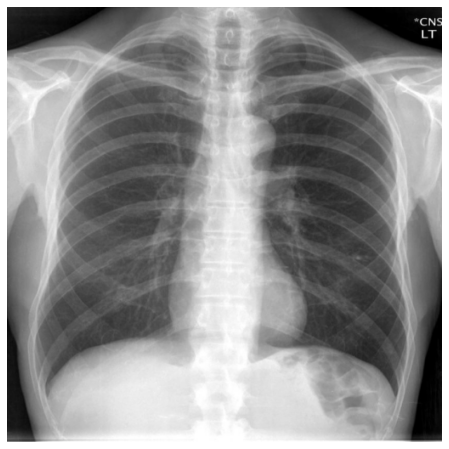

In [164]:
plt.figure(figsize=(8, 8))

plt.imshow(arr_to_range(image.permute(1, 2, 0)))
plt.axis('off')

#### Plot with attention

In [165]:
att = tup[1][0].detach().cpu().numpy()
att.shape

(100, 16, 16)

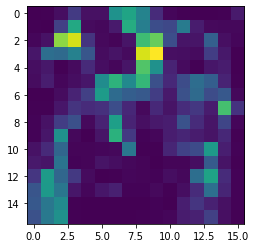

In [171]:
plt.imshow(att[-10])

In [210]:
att_idx = 13

In [211]:
len(att)

100

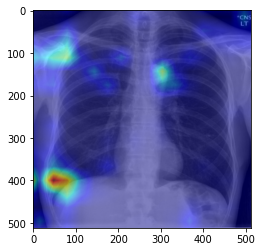

In [212]:
# Transpose image to plot with imshow
norm_image_CHW = arr_to_range(image.detach().cpu().numpy())
norm_image_HWC = norm_image_CHW.transpose(1, 2, 0)

# Resize activation
height, width = norm_image_HWC.shape[:2]
act = resize(att[att_idx], (height, width))
act = arr_to_range(act, 0, 1)

# Apply pretty colormap
cm = plt.get_cmap('jet')
act = cm(act)

# Add both images
image_plus_act = (norm_image_HWC + act[:, :, :3]) # / 2
image_plus_act = arr_to_range(image_plus_act)

plt.imshow(image_plus_act)

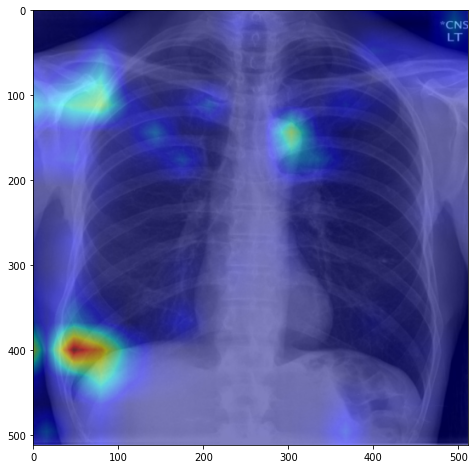

In [213]:
plt.figure(figsize=(8, 8))

plt.imshow(image_plus_act)

### Search reports with a certain pattern

In [24]:
from tqdm.notebook import tqdm
import re

In [65]:
# target = re.compile(r'\A[a-zA-Z]+ size is normal')
target = re.compile('both lungs are clear and expanded')
found = []

for report in train_dataset.reports:
    report = idx_to_text(report['tokens_idxs'])
    if target.search(report):
        found.append(report)

len(found)

162

In [70]:
found_diff = list(set(found))
len(found_diff)

19

In [76]:
found_diff[5]

'chest . both lungs are clear and expanded with no pleural air collections or parenchymal consolidations . heart and mediastinum remain normal . lumbosacral spine . xxxx , disc spaces , and alignment are normal . sacrum and sacroiliac joints are normal . END'

## Debug att-supervision loss

In [237]:
%run ../losses/out_of_target.py

In [233]:
masks1 = train_dataloader.dataset[30].masks
masks2 = train_dataloader.dataset[100].masks
masks3 = train_dataloader.dataset[200].masks
masks4 = train_dataloader.dataset[1].masks
target = torch.stack([torch.stack([masks1, masks2]), torch.stack([masks3, masks4])])
target.size()

torch.Size([2, 2, 256, 256])

In [234]:
shape = target.size()[:2]
output = torch.rand(*shape, 16, 16)
# output = torch.ones(*target.size())
output = output.view(*shape, -1)
output = torch.softmax(output, dim=-1)
output = output.view(*shape, 16, 16)
output.size()

torch.Size([2, 2, 16, 16])

In [235]:
loss = OutOfTargetSumLoss()
x = loss(output, target)
x.item()

0.5921783447265625

torch.Size([2, 2, 256, 256])

In [123]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [163]:
# target = (torch.rand(1, 1, 256, 256) > 0.5).long()
target = masks
target.size()

torch.Size([2, 2, 256, 256])

In [164]:
target2 = interpolate(target.float(), size=(16, 16), mode='nearest')
target2.size()

torch.Size([2, 2, 16, 16])

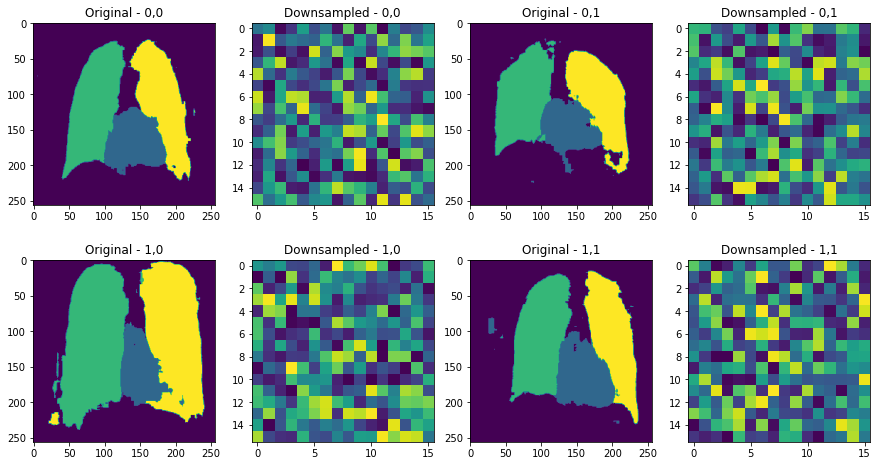

In [236]:
batch_size, n_sentences = target.size()[:2]

n_rows = batch_size
n_cols = n_sentences * 2

plt.figure(figsize=(15, 8))

plot_index = 1
for idx1 in range(batch_size):
    for idx2 in range(n_sentences):
        plt.subplot(n_rows, n_cols, plot_index)
        plt.imshow(target[idx1][idx2])
        plt.title(f'Original - {idx1},{idx2}')
        plot_index += 1
        
        plt.subplot(n_rows, n_cols, plot_index)
        plt.imshow(output[idx1][idx2])
        plt.title(f'Downsampled - {idx1},{idx2}')
        plot_index += 1

In [143]:
masks.min(), masks.max()

(tensor(0), tensor(3))

In [172]:
target2.min(), target2.max()

(tensor(0.), tensor(3.))

In [147]:
from collections import Counter

In [174]:
Counter(x.item() for x in target2.long().view(-1))

Counter({0: 605, 2: 177, 3: 153, 1: 89})

In [149]:
target2 = target2.long()